Inisialisasi Package

In [3]:
import tensorflow as tf
import wandb
from keras.applications import DenseNet121
from datasets import load_dataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Load Dataset

In [18]:
dataset = load_dataset("garythung/trashnet")
print(dataset)

Found cached dataset imagefolder (C:/Users/Muhammad Asyarie/.cache/huggingface/datasets/garythung___imagefolder/garythung--trashnet-9661a209e95116dc/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})


Image Example

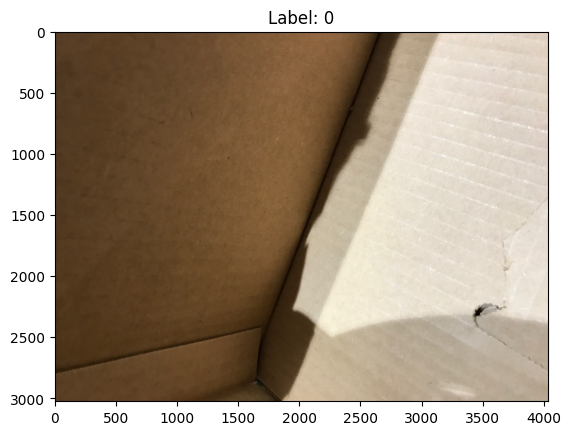

In [5]:
# Ambil satu contoh data dari dataset
sample = dataset['train'][0]

# Ambil gambar dan labelnya
image = sample['image']
label = sample['label']

# Tampilkan gambar
plt.imshow(image)
plt.title(f"Label: {label}")
plt.show()


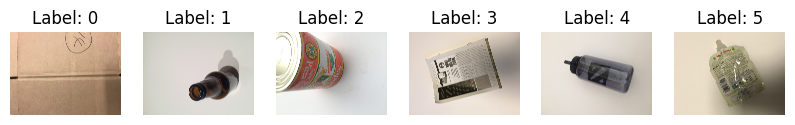

In [65]:
unique_labels = set(item['label'] for item in dataset['train'])

# Inisialisasi dictionary untuk menyimpan contoh gambar dari setiap kelas
sample_images = {}

# Loop melalui data untuk mengumpulkan satu gambar per kelas
for sample in dataset['train']:
    label = sample['label']
    if label not in sample_images:
        sample_images[label] = sample['image']
    # Berhenti setelah mendapat satu contoh per kelas
    if len(sample_images) == len(unique_labels):
        break

# Plot setiap gambar dari kelas yang berbeda
plt.figure(figsize=(10, 10))
for idx, (label, image) in enumerate(sample_images.items()):
    plt.subplot(1, len(unique_labels), idx + 1)
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

Exploratory Data Analysis

ClassLabel(names=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], id=None)


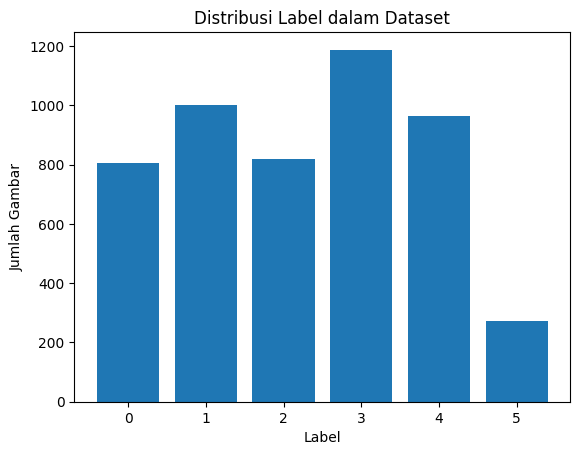

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

# Distribusi label
labels = [sample['label'] for sample in dataset['train']]
label_distribution = Counter(labels)

print(dataset['train'].features['label'])
plt.bar(label_distribution.keys(), label_distribution.values())
plt.title('Distribusi Label dalam Dataset')
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.show()


Split Data

In [20]:
# Memisahkan dataset menjadi 80% train dan 20% validation
train_test_split = dataset['train'].train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
validation_dataset = train_test_split['test']

# Menampilkan ukuran dari masing-masing subset
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(validation_dataset)}")


Train size: 4043
Validation size: 1011


Balancing Data using Class weight

In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_dataset['label']  # Daftar semua label di dataset training
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

print(f"Class weights: {class_weights_dict}")


Class weights: {0: 1.047952306894764, 1: 0.8298440065681445, 2: 1.0495846313603323, 3: 0.702641640597845, 4: 0.8717119448037948, 5: 3.148753894080997}


Inisialisasi Wandb

In [ ]:
wandb.init(project="trashnet-classification", config={
    "model": "DenseNet121",
    "batch_size": 32,
    "epochs": 10,
    "learning_rate": 0.001,
    "image_size": (224, 224)
})

Preprocessing dan dataset generator

In [ ]:
def preprocess(example):
    image = tf.image.resize(example['image'], [224, 224]) / 255.0
    label = tf.one_hot(example['label'], depth=len(class_weights_dict))
    return image, label

# 4. Dataset generator
def dataset_generator(dataset):
    for example in dataset:
        yield preprocess(example)

train_ds = tf.data.Dataset.from_generator(
    lambda: dataset_generator(train_dataset),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(len(class_weights_dict),), dtype=tf.float32),
    )
)

val_ds = tf.data.Dataset.from_generator(
    lambda: dataset_generator(validation_dataset),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(len(class_weights_dict),), dtype=tf.float32),
    )
)


Build Model

In [1]:

augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

train_ds = train_ds.map(lambda x, y: (augmentation(x, training=True), y), 
                        num_parallel_calls=tf.data.AUTOTUNE)

# 6. Batch, repeat, dan prefetch
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)

# Definisikan model
base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_weights_dict), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training dengan WandB Callback
steps_per_epoch = len(train_dataset) // BATCH_SIZE
validation_steps = len(validation_dataset) // BATCH_SIZE

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights_dict,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[wandb.keras.WandbCallback()]
)

# Evaluasi model
val_loss, val_accuracy = model.evaluate(val_ds, steps=validation_steps)
print(f"Validation Accuracy: {val_accuracy}")

# Save model di direktori wandb untuk versioning
model.save(f"{wandb.run.dir}/model.h5")

# Log model ke WandB sebagai artifact
wandb.log_artifact(f"{wandb.run.dir}/model.h5", name="densenet_trashnet_model", type="model")

# Akhiri sesi WandB
wandb.finish()


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Muhammad Asyarie\_netrc


Found cached dataset imagefolder (C:/Users/Muhammad Asyarie/.cache/huggingface/datasets/garythung___imagefolder/garythung--trashnet-9661a209e95116dc/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
126/126 [==============================] - ETA: 0s - loss: 1.2105 - accuracy: 0.5355

INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets


INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets
wandb: Adding directory to artifact (d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best)... Done. 0.1s


126/126 [==============================] - 490s 4s/step - loss: 1.2105 - accuracy: 0.5355 - val_loss: 0.7337 - val_accuracy: 0.7379
Epoch 2/10
126/126 [==============================] - ETA: 0s - loss: 0.8189 - accuracy: 0.6884

INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets


INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets
wandb: Adding directory to artifact (d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best)... Done. 0.1s


126/126 [==============================] - 464s 4s/step - loss: 0.8189 - accuracy: 0.6884 - val_loss: 0.5773 - val_accuracy: 0.7994
Epoch 3/10
126/126 [==============================] - ETA: 0s - loss: 0.7127 - accuracy: 0.7372

INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets


INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets
wandb: Adding directory to artifact (d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best)... Done. 0.1s


126/126 [==============================] - 582s 5s/step - loss: 0.7127 - accuracy: 0.7372 - val_loss: 0.5416 - val_accuracy: 0.8175
Epoch 4/10
126/126 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.7744

INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets


INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets
wandb: Adding directory to artifact (d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best)... Done. 0.1s


126/126 [==============================] - 626s 5s/step - loss: 0.6274 - accuracy: 0.7744 - val_loss: 0.4868 - val_accuracy: 0.8216
Epoch 5/10
126/126 [==============================] - ETA: 0s - loss: 0.5857 - accuracy: 0.7881

INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets


INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets
wandb: Adding directory to artifact (d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best)... Done. 0.1s


126/126 [==============================] - 746s 6s/step - loss: 0.5857 - accuracy: 0.7881 - val_loss: 0.4418 - val_accuracy: 0.8387
Epoch 6/10
126/126 [==============================] - ETA: 0s - loss: 0.5259 - accuracy: 0.8045

INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets


INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets
wandb: Adding directory to artifact (d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best)... Done. 0.1s


126/126 [==============================] - 708s 6s/step - loss: 0.5259 - accuracy: 0.8045 - val_loss: 0.4279 - val_accuracy: 0.8528
Epoch 7/10
126/126 [==============================] - 686s 5s/step - loss: 0.5002 - accuracy: 0.8163 - val_loss: 0.4325 - val_accuracy: 0.8417
Epoch 8/10
126/126 [==============================] - ETA: 0s - loss: 0.4874 - accuracy: 0.8255

INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets


INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets
wandb: Adding directory to artifact (d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best)... Done. 0.2s


126/126 [==============================] - 817s 7s/step - loss: 0.4874 - accuracy: 0.8255 - val_loss: 0.4182 - val_accuracy: 0.8508
Epoch 9/10
126/126 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.8342

INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets


INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets
wandb: Adding directory to artifact (d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best)... Done. 0.1s


126/126 [==============================] - 813s 6s/step - loss: 0.4432 - accuracy: 0.8342 - val_loss: 0.4021 - val_accuracy: 0.8548
Epoch 10/10
126/126 [==============================] - ETA: 0s - loss: 0.4426 - accuracy: 0.8355

INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets


INFO:tensorflow:Assets written to: d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best\assets
wandb: Adding directory to artifact (d:\Kode python\trash_classification\wandb\run-20241028_143626-cgh31nxi\files\model-best)... Done. 0.1s


31/31 [==============================] - 151s 5s/step - loss: 0.3682 - accuracy: 0.8669
Validation Accuracy: 0.8669354915618896


accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇█
val_loss,█▅▄▃▂▂▂▂▂▁
accuracy,0.83545
best_epoch,9
best_val_loss,0.36825
epoch,9
loss,0.4426
val_accuracy,0.86694


Metrics

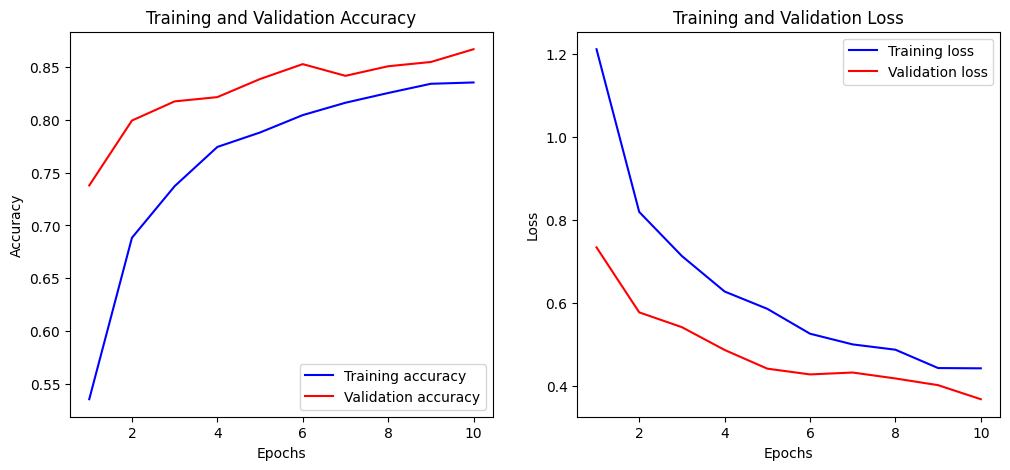

In [5]:
def plot_training_metrics(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b', label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_metrics(history)

Prediction

1/1 [==============================] - 8s 8s/step


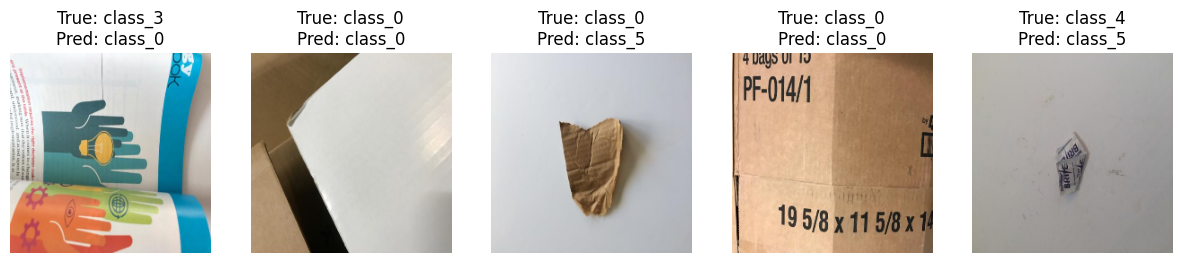

In [4]:
def predict_and_visualize(model, dataset, class_names):
    images, labels = next(iter(dataset))  # Get a batch of validation images and labels
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)

    # Visualize the first 5 predictions with their true labels
    plt.figure(figsize=(15, 10))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        plt.axis("off")
    plt.show()

# Define class names according to the dataset
class_names = ["class_0", "class_1", "class_2", "class_3", "class_4", "class_5"]  # Replace with actual class names
predict_and_visualize(model, val_ds, class_names)

Confusion Matrix

In [6]:
def plot_confusion_matrix(model, dataset, class_names):
    y_true = []
    y_pred = []

    # Collect predictions and true labels from the validation set
    for images, labels in dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels, axis=1))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm_display.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, val_ds, class_names)

1/1 [==============================] - 4s 4s/step


KeyboardInterrupt: 